In [7]:
import json
import glob, pickle

import numpy as np
import pandas as pd

from qiskit import transpile
from qiskit import execute
from qiskit.providers.fake_provider import FakeLima
from qiskit.primitives import Estimator
from qiskit.circuit.random import random_circuit

import torch
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn.functional import dropout

from torch_geometric.nn import GCNConv, global_mean_pool, Linear, ChebConv, SAGEConv
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

from tqdm.notebook import tqdm_notebook
import matplotlib.pyplot as plt
import seaborn as sns

from blackwater.data.loaders.exp_val import CircuitGraphExpValMitigationDataset
from blackwater.data.generators.exp_val import exp_value_generator
from blackwater.data.utils import generate_random_pauli_sum_op
from blackwater.library.ngem.estimator import ngem

from qiskit.quantum_info import random_clifford

import random
from qiskit.circuit.library import HGate, SdgGate
from qiskit.circuit import ClassicalRegister

from blackwater.data.utils import (
    generate_random_pauli_sum_op,
    create_estimator_meas_data,
    circuit_to_graph_data_json,
    get_backend_properties_v1,
    encode_pauli_sum_op,
    create_meas_data_from_estimators
)
from blackwater.data.generators.exp_val import ExpValueEntry
from blackwater.metrics.improvement_factor import improvement_factor, Trial, Problem

from qiskit_aer import AerSimulator, QasmSimulator
from qiskit.providers.fake_provider import FakeMontreal, FakeLima, FakeBelem

from torch_geometric.nn import (
    GCNConv,
    TransformerConv,
    GATv2Conv,
    global_mean_pool,
    Linear,
    ChebConv,
    SAGEConv,
    ASAPooling,
    dense_diff_pool,
    avg_pool_neighbor_x
)
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_dense_adj, to_dense_batch

from qiskit import QuantumCircuit
from qiskit.circuit.library import U3Gate, CZGate, PhaseGate, CXGate
from mbd_utils import construct_random_clifford, cal_z_exp, calc_imbalance, cal_all_z_exp, construct_mbl_circuit, generate_disorder
from gnn import ExpValCircuitGraphModel
plt.style.use({'figure.facecolor':'white'})

In [8]:
backend_lima = FakeLima()
backend_belem = FakeBelem()
backend_montreal = FakeMontreal()
properties_lima = get_backend_properties_v1(backend_lima)
properties_belem = get_backend_properties_v1(backend_belem)
properties_montreal = get_backend_properties_v1(backend_montreal)

## Local
backend_ideal = QasmSimulator() # Noiseless
backend_noisy_lima = AerSimulator.from_backend(backend_lima) # Noisy
backend_noisy_belem = AerSimulator.from_backend(backend_belem) # Noisy
backend_noisy_montreal = AerSimulator.from_backend(backend_montreal) # Noisy

run_config_ideal = {'shots': 10000, 'backend': backend_ideal, 'name': 'ideal'}
run_config_noisy_lima = {'shots': 10000, 'backend': backend_noisy_lima, 'name': 'noisy_lima'}
run_config_noisy_belem = {'shots': 10000, 'backend': backend_noisy_belem, 'name': 'noisy_belem'}
run_config_noisy_montreal = {'shots': 10000, 'backend': backend_noisy_montreal, 'name': 'noisy_montreal'}

BATCH_SIZE = 32

# Train on Backend 1

In [3]:
train_paths = [
    f'./data/circ_parsed_pyg_data/train/fakelima_depth{i}.json' for i in range(1, 10)
]

val_paths = [
    f'./data/circ_parsed_pyg_data/val/fakelima/fakelima_depth{i}.json' for i in range(1, 10)
]

In [4]:
train_loader = DataLoader(
    CircuitGraphExpValMitigationDataset(
        train_paths,
    ),
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_loader = DataLoader(
    CircuitGraphExpValMitigationDataset(
        val_paths,
    ),
    batch_size=BATCH_SIZE,
    shuffle=False
)

for data in train_loader:
    print(data)
    break

DataBatch(x=[742, 22], edge_index=[2, 1630], edge_attr=[888, 3], y=[32, 1, 1], observable=[32, 0], circuit_depth=[32, 1], noisy_0=[32, 1, 1], batch=[742], ptr=[33])


In [5]:
model = ExpValCircuitGraphModel(
    num_node_features=22,
    hidden_channels=15,
    exp_value_size=1,
)
criterion = torch.nn.MSELoss()

optimizer = Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer,
                              'min',
                              factor=0.1,
                              patience=15,
                              verbose=True,
                              min_lr=0.00001)

In [6]:
print(sum(p.numel() for p in model.parameters() if p.requires_grad), len(train_loader) * BATCH_SIZE, len(val_loader) * BATCH_SIZE)

13552 9024 3616


In [8]:
min_valid_loss = np.inf

train_losses = []
val_losses = []

N_EPOCHS = 50

progress = tqdm_notebook(range(N_EPOCHS), desc='Model training', leave=True)
for epoch in progress:
    train_loss = 0.0
    model.train()
    for i, data in enumerate(train_loader):
        optimizer.zero_grad()

        out = model(
            data.noisy_0,
            data.observable,
            data.circuit_depth,
            data.x,
            data.edge_index,
            data.batch
        )
        loss = criterion(out, torch.squeeze(data.y, 1))

        train_loss += loss.item()

        loss.backward()
        optimizer.step()

    valid_loss = 0.0
    model.eval()
    for i, data in enumerate(val_loader):
        out = model(
            data.noisy_0,
            data.observable,
            data.circuit_depth,
            data.x,
            data.edge_index,
            data.batch)
        loss = criterion(out, torch.squeeze(data.y, 1))

        valid_loss += loss.item()

    scheduler.step(valid_loss)

    if epoch >= 1:
        train_losses.append(train_loss / len(train_loader))
        val_losses.append(valid_loss / len(val_loader))

        progress.set_description(f"{round(train_losses[-1], 5)}, {round(val_losses[-1], 5)}")
        progress.refresh()

Model training:   0%|          | 0/50 [00:00<?, ?it/s]

In [14]:
# with open('./model/finetuning/train_fakelima.pk', 'rb') as in_file:
#     curves = pickle.load(in_file)
#
# train_losses, val_losses = curves['train_losses'], curves['val_losses']

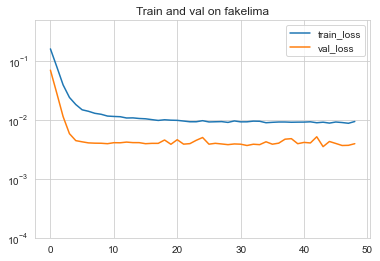

In [22]:
plt.style.use({'figure.facecolor':'white'})
plt.plot(train_losses, label="train_loss")
plt.plot(val_losses, label="val_loss")
plt.title('Train and val on fakelima')
plt.yscale('log')
plt.ylim([0.0001, 0.5])

plt.legend()
plt.show()

In [13]:
model_path = './model/finetuning/train_fakelima.pth'

In [14]:
# torch.save(model.state_dict(), model_path)

In [15]:
# to_save = {'train_losses': train_losses, 'val_losses': val_losses}
# with open('.'+model_path.split('.')[1]+'.pk', 'wb') as handle:
#     pickle.dump(to_save, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Test on Backend 2

In [3]:
model_path = './model/finetuning/train_fakelima.pth'

In [4]:
model = ExpValCircuitGraphModel(
    num_node_features=22,
    hidden_channels=15,
    exp_value_size=1
)
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [5]:
dfs = {}
model.eval()
for d in tqdm_notebook(range(1, 10)):
    test_paths = [
        f'./data/circ_parsed_pyg_data/val/fakemontreal_depth{d}.json'
    ]

    test_loader = DataLoader(
        CircuitGraphExpValMitigationDataset(
            test_paths,
        ),
        batch_size=1000000,
        shuffle=False
    )

    distances = []
    for i, data in enumerate(test_loader):
        out = model(data.noisy_0, data.observable, data.circuit_depth, data.x, data.edge_index, data.batch)

        for ideal, noisy, ngm_mitigated in zip(
            data.y.tolist(),
            data.noisy_0.tolist(),
            out.tolist()
        ):
            ideal = np.squeeze(ideal)
            noisy = np.squeeze(noisy)
            ngm_mitigated = np.squeeze(ngm_mitigated)
            distances.append({
                "ideal": ideal,
                "noisy": noisy,
                "ngm_mitigated": ngm_mitigated,
                "dist_noisy": np.abs(ideal - noisy),
                "dist_ngm": np.abs(ideal - ngm_mitigated),
            })

    df = pd.DataFrame(distances)
    dfs[d] = df

  0%|          | 0/9 [00:00<?, ?it/s]

In [8]:
plt.style.use({'figure.facecolor':'white'})

y_dist_noisy = []
y_dist_ngm = []
for depth in dfs.keys():
    y_dist_noisy.append(dfs[depth]['dist_noisy'].mean())
    y_dist_ngm.append(dfs[depth]['dist_ngm'].mean())

plt.plot(np.arange(1, 10), y_dist_noisy, label='dist_noisy')
plt.plot(np.arange(1, 10), y_dist_ngm, label='dist_ngm')
plt.ylim([0, 0.15])
plt.title('Train on fakelima, test on fakemontreal')
plt.ylabel('<O-O_ideal>')
plt.xlabel('d')
plt.legend()

In [22]:
all_report_data = []

ngem_improvement_factors = {}
zne_improvement_factors = {}

ideal_means = []
noisy_means = []
ngem_mitigated_means = []
zne_mitigated_means = []

for depth in tqdm_notebook(range(1, 10)):
    test_paths = [
        f'./data/circ_parsed_pyg_data/val/fakemontreal_depth{depth}.json'
    ]

    if len(test_paths) == 0: continue

    test_loader = DataLoader(
        CircuitGraphExpValMitigationDataset(
            test_paths,
        ),
        batch_size=BATCH_SIZE,
        shuffle=False
    )

    ngem_problems = []

    ideal_values = []
    ngem_values = []
    noisy_valuses = []

    for i, data in enumerate(test_loader):
        out = model(
            data.noisy_0,
            data.observable,
            data.circuit_depth,
            data.x,
            data.edge_index,
            data.batch)

        for ideal, noisy, ngm_mitigated in zip(
            data.y.squeeze().tolist(),
            data.noisy_0.squeeze().tolist(),
            out.squeeze().tolist()
        ):
            ngem_problem = Problem(
                trials=[Trial(noisy=noisy, mitigated=ngm_mitigated)],
                ideal_exp_value=ideal
            )
            ngem_problems.append(ngem_problem)

            ideal_values.append(ideal)
            ngem_values.append(np.abs(ideal - ngm_mitigated))
            noisy_valuses.append(np.abs(ideal - noisy))

            all_report_data.append({
                "ideal": ideal,
                "ngem": ngm_mitigated,
                "noisy": noisy,
                "depth": depth
            })

    ideal_means.append(np.average(ideal_values))
    noisy_means.append(np.average(noisy_valuses))
    ngem_mitigated_means.append(np.average(ngem_values))

    ngem_improvement_factors[depth] = improvement_factor(ngem_problems, 1, 1)

  0%|          | 0/9 [00:00<?, ?it/s]

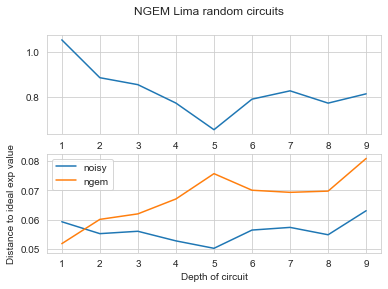

In [23]:
kwargs = {"capsize": 10, "lw": 2}

fig, (ax1, ax2) = plt.subplots(2)
# fig, ax2 = plt.subplots(1)
fig.suptitle('NGEM Lima random circuits')

dapth_data = list(range(1, 10))

ax1.plot(dapth_data, ngem_improvement_factors.values(), label="ngem")

ax2.plot(dapth_data, noisy_means, label="noisy")
ax2.plot(dapth_data, ngem_mitigated_means, label="ngem")

plt.xlabel("Depth of circuit")
plt.ylabel("Distance to ideal exp value")
plt.legend()
plt.show()

# Finetune on Backend 2

In [3]:
model_path = './model/finetuning/train_fakelima.pth'

In [4]:
model = ExpValCircuitGraphModel(
    num_node_features=22,
    hidden_channels=15,
    exp_value_size=1
)
model.load_state_dict(torch.load(model_path))

criterion = torch.nn.MSELoss()

optimizer = Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer,
                              'min',
                              factor=0.1,
                              patience=15,
                              verbose=True,
                              min_lr=0.00001)

In [5]:
finetune_paths = [
    f'./data/circ_parsed_pyg_data/finetune/fakemontreal_depth{i}.json' for i in range(1, 10)
]

test_paths = [
    f'./data/circ_parsed_pyg_data/val/fakemontreal_depth{i}.json' for i in range(1, 10)
]

finetune_loader = DataLoader(
    CircuitGraphExpValMitigationDataset(
        finetune_paths,
    ),
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_loader = DataLoader(
    CircuitGraphExpValMitigationDataset(
        test_paths,
    ),
    batch_size=BATCH_SIZE,
    shuffle=False
)

In [6]:
print(sum(p.numel() for p in model.parameters() if p.requires_grad), len(finetune_loader) * BATCH_SIZE, len(test_loader) * BATCH_SIZE)

13552 3616 3616


In [7]:
min_valid_loss = np.inf

finetune_losses = []
test_losses = []

N_EPOCHS = 50

progress = tqdm_notebook(range(N_EPOCHS), desc='Model training', leave=True)
for epoch in progress:
    finetune_loss = 0.0
    model.train()
    for i, data in enumerate(finetune_loader):
        optimizer.zero_grad()

        out = model(
            data.noisy_0,
            data.observable,
            data.circuit_depth,
            data.x,
            data.edge_index,
            data.batch
        )
        loss = criterion(out, torch.squeeze(data.y, 1))

        finetune_loss += loss.item()

        loss.backward()
        optimizer.step()

    test_loss = 0.0
    model.eval()
    for i, data in enumerate(test_loader):
        out = model(
            data.noisy_0,
            data.observable,
            data.circuit_depth,
            data.x,
            data.edge_index,
            data.batch)
        loss = criterion(out, torch.squeeze(data.y, 1))

        test_loss += loss.item()

    scheduler.step(test_loss)

    if epoch >= 1:
        finetune_losses.append(finetune_loss / len(finetune_loader))
        test_losses.append(test_loss / len(test_loader))

        progress.set_description(f"{round(finetune_losses[-1], 5)}, {round(test_losses[-1], 5)}")
        progress.refresh()

Model training:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 00029: reducing learning rate of group 0 to 1.0000e-04.
Epoch 00045: reducing learning rate of group 0 to 1.0000e-05.


In [18]:
with open('./model/finetuning/finetune_fakemontreal.pk', 'rb') as in_file:
    curves = pickle.load(in_file)

finetune_losses, test_losses = curves['finetune_losses'], curves['test_losses']

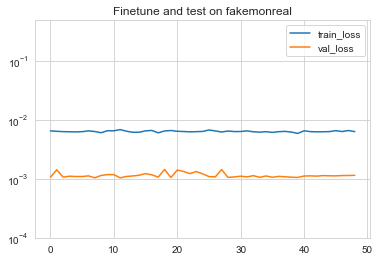

In [23]:
plt.style.use({'figure.facecolor':'white'})
plt.plot(finetune_losses, label="train_loss")
plt.plot(test_losses, label="val_loss")
plt.title('Finetune and test on fakemonreal')
plt.yscale('log')
plt.ylim([0.0001, 0.5])

plt.legend()
plt.show()

In [12]:
model_path = './model/finetuning/finetune_fakemontreal.pth'

In [13]:
# torch.save(model.state_dict(), model_path)

In [15]:
# to_save = {'finetune_losses': finetune_losses, 'test_losses': test_losses}
# with open('.'+model_path.split('.')[1]+'.pk', 'wb') as handle:
#     pickle.dump(to_save, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Test on Backend 2

In [3]:
model_path = './model/finetuning/finetune_fakemontreal.pth'

In [4]:
model = ExpValCircuitGraphModel(
    num_node_features=22,
    hidden_channels=15,
    exp_value_size=1
)
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [5]:
dfs = {}
model.eval()
for d in tqdm_notebook(range(1, 10)):
    test_paths = [
        f'./data/circ_parsed_pyg_data/val/fakemontreal_depth{d}.json'
    ]

    test_loader = DataLoader(
        CircuitGraphExpValMitigationDataset(
            test_paths,
        ),
        batch_size=10000000,
        shuffle=False
    )

    distances = []
    for i, data in enumerate(test_loader):
        out = model(data.noisy_0, data.observable, data.circuit_depth, data.x, data.edge_index, data.batch)

        for ideal, noisy, ngm_mitigated in zip(
            data.y.tolist(),
            data.noisy_0.tolist(),
            out.tolist()
        ):
            ideal = np.mean(ideal)
            noisy = np.mean(noisy)
            ngm_mitigated = np.mean(ngm_mitigated)
            distances.append({
                "ideal": ideal,
                "noisy": noisy,
                "ngm_mitigated": ngm_mitigated,
                "dist_noisy": np.abs(ideal - noisy),
                "dist_ngm": np.abs(ideal - ngm_mitigated),
            })

    df = pd.DataFrame(distances)
    dfs[d] = df

  0%|          | 0/9 [00:00<?, ?it/s]

In [8]:
# with open('./results_to_plot/finetuning/train_lima_finetune_montreal_test_montreal.pk', 'wb') as out:
#     pickle.dump(dfs, out)

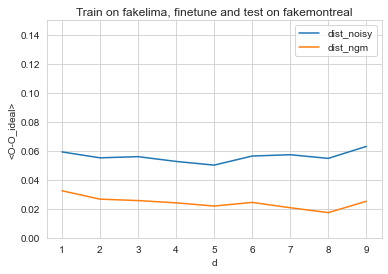

In [7]:
plt.style.use({'figure.facecolor':'white'})

y_dist_noisy = []
y_dist_ngm = []
for depth in dfs.keys():
    y_dist_noisy.append(dfs[depth]['dist_noisy'].mean())
    y_dist_ngm.append(dfs[depth]['dist_ngm'].mean())

plt.plot(np.arange(1, 10), y_dist_noisy, label='dist_noisy')
plt.plot(np.arange(1, 10), y_dist_ngm, label='dist_ngm')
plt.ylim([0, 0.15])
plt.title('Train on fakelima, finetune and test on fakemontreal')
plt.ylabel('<O-O_ideal>')
plt.xlabel('d')
plt.legend()

# Train on Backend 2 (from scratch)

In [9]:
train_paths = [
    f'./data/circ_parsed_pyg_data/train/fakemontreal_depth{i}.json' for i in range(1, 10)
]

val_paths = [
    f'./data/circ_parsed_pyg_data/val/fakemontreal_depth{i}.json' for i in range(1, 10)
]

In [10]:
train_loader = DataLoader(
    CircuitGraphExpValMitigationDataset(
        train_paths,
    ),
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_loader = DataLoader(
    CircuitGraphExpValMitigationDataset(
        val_paths,
    ),
    batch_size=BATCH_SIZE,
    shuffle=False
)

for data in train_loader:
    print(data)
    break

DataBatch(x=[759, 22], edge_index=[2, 1607], edge_attr=[848, 3], y=[32, 1, 1], observable=[32, 0], circuit_depth=[32, 1], noisy_0=[32, 1, 1], batch=[759], ptr=[33])


In [11]:
model = ExpValCircuitGraphModel(
    num_node_features=22,
    hidden_channels=15,
    exp_value_size=1,
)
criterion = torch.nn.MSELoss()

optimizer = Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer,
                              'min',
                              factor=0.1,
                              patience=15,
                              verbose=True,
                              min_lr=0.00001)

print(sum(p.numel() for p in model.parameters() if p.requires_grad), len(train_loader) * BATCH_SIZE, len(val_loader) * BATCH_SIZE)

13552 9024 3616


In [12]:
min_valid_loss = np.inf

train_losses = []
val_losses = []

N_EPOCHS = 50

progress = tqdm_notebook(range(N_EPOCHS), desc='Model training', leave=True)
for epoch in progress:
    train_loss = 0.0
    model.train()
    for i, data in enumerate(train_loader):
        optimizer.zero_grad()

        out = model(
            data.noisy_0,
            data.observable,
            data.circuit_depth,
            data.x,
            data.edge_index,
            data.batch
        )
        loss = criterion(out, torch.squeeze(data.y, 1))

        train_loss += loss.item()

        loss.backward()
        optimizer.step()

    valid_loss = 0.0
    model.eval()
    for i, data in enumerate(val_loader):
        out = model(
            data.noisy_0,
            data.observable,
            data.circuit_depth,
            data.x,
            data.edge_index,
            data.batch)
        loss = criterion(out, torch.squeeze(data.y, 1))

        valid_loss += loss.item()

    scheduler.step(valid_loss)

    if epoch >= 1:
        train_losses.append(train_loss / len(train_loader))
        val_losses.append(valid_loss / len(val_loader))

        progress.set_description(f"{round(train_losses[-1], 5)}, {round(val_losses[-1], 5)}")
        progress.refresh()

Model training:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 00030: reducing learning rate of group 0 to 1.0000e-04.


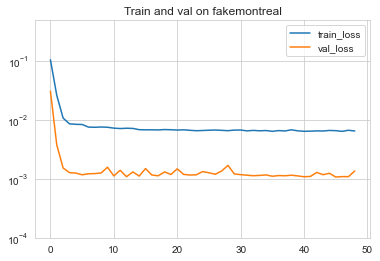

In [19]:
plt.style.use({'figure.facecolor':'white'})
plt.plot(train_losses, label="train_loss")
plt.plot(val_losses, label="val_loss")
plt.title('Train and val on fakemontreal')
plt.yscale('log')
plt.ylim([0.0001, 0.5])

plt.legend()
plt.show()

In [16]:
model_path = './model/finetuning/train_fakemontreal.pth'

In [17]:
# torch.save(model.state_dict(), model_path)

In [18]:
# to_save = {'train_losses': train_losses, 'val_losses': val_losses}
# with open('.'+model_path.split('.')[1]+'.pk', 'wb') as handle:
#     pickle.dump(to_save, handle, protocol=pickle.HIGHEST_PROTOCOL)

  0%|          | 0/9 [00:00<?, ?it/s]

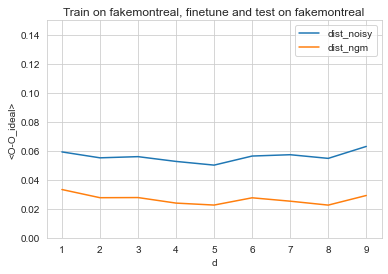

In [20]:
# model_path = './model/finetuning/train_fakemontreal.pth'
# model = ExpValCircuitGraphModel(
#     num_node_features=22,
#     hidden_channels=15,
#     exp_value_size=1
# )
# model.load_state_dict(torch.load(model_path))

dfs = {}
model.eval()
for d in tqdm_notebook(range(1, 10)):
    test_paths = [
        f'./data/circ_parsed_pyg_data/val/fakemontreal_depth{d}.json'
    ]

    test_loader = DataLoader(
        CircuitGraphExpValMitigationDataset(
            test_paths,
        ),
        batch_size=10000000,
        shuffle=False
    )

    distances = []
    for i, data in enumerate(test_loader):
        out = model(data.noisy_0, data.observable, data.circuit_depth, data.x, data.edge_index, data.batch)

        for ideal, noisy, ngm_mitigated in zip(
                data.y.tolist(),
                data.noisy_0.tolist(),
                out.tolist()
        ):
            ideal = np.mean(ideal)
            noisy = np.mean(noisy)
            ngm_mitigated = np.mean(ngm_mitigated)
            distances.append({
                "ideal": ideal,
                "noisy": noisy,
                "ngm_mitigated": ngm_mitigated,
                "dist_noisy": np.abs(ideal - noisy),
                "dist_ngm": np.abs(ideal - ngm_mitigated),
            })

    df = pd.DataFrame(distances)
    dfs[d] = df
plt.style.use({'figure.facecolor': 'white'})

y_dist_noisy = []
y_dist_ngm = []
for depth in dfs.keys():
    y_dist_noisy.append(dfs[depth]['dist_noisy'].mean())
    y_dist_ngm.append(dfs[depth]['dist_ngm'].mean())

plt.plot(np.arange(1, 10), y_dist_noisy, label='dist_noisy')
plt.plot(np.arange(1, 10), y_dist_ngm, label='dist_ngm')
plt.ylim([0, 0.15])
plt.title('Train on fakemontreal, finetune and test on fakemontreal')
plt.ylabel('<O-O_ideal>')
plt.xlabel('d')
plt.legend()

In [21]:
# with open('./results_to_plot/finetuning/train_montreal_finetune_montreal_test_montreal.pk', 'wb') as out:
#     pickle.dump(dfs, out)